# Autoencoders, Detecting Malicious URLs

## Malicious URLs

In [1]:
import pandas as pd

mdf = pd.read_csv('./cybersecurity/csv.txt', index_col=0)
mdf.shape

(294903, 8)

In [2]:
mdf.head()

,dateadded,url,url_status,last_online,threat,tags,urlhaus_link,reporter
id,,,,,,,,
1959127,2022-01-09 04:09:07,http://113.178.137.103:43063/bin.sh,online,None,malware_download,"32-bit,elf,mips,Mozi",https://urlhaus.abuse.ch/url/1959127/,geenensp
1959126,2022-01-09 04:09:06,http://117.195.92.136:52193/bin.sh,online,None,malware_download,"32-bit,elf,mips,Mozi",https://urlhaus.abuse.ch/url/1959126/,geenensp
1959125,2022-01-09 04:08:05,http://42.230.86.76:39194/i,online,None,malware_download,"32-bit,elf,mips,Mozi",https://urlhaus.abuse.ch/url/1959125/,geenensp
1959124,2022-01-09 04:07:06,http://45.206.219.185:39528/Mozi.m,online,None,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/1959124/,lrz_urlhaus
1959123,2022-01-09 04:07:05,http://182.117.30.44:43217/bin.sh,online,None,malware_download,"32-bit,elf,mips,Mozi",https://urlhaus.abuse.ch/url/1959123/,geenensp


## Fake URLs

In [3]:
from faker import Faker
import numpy as np
import random

np.random.seed(37)
random.seed(37)
Faker.seed(37)

def get_fake_url(f):
    def get_slash_index(u):
        indices = [i for i, c in enumerate(u) if c == '/']
        return indices[2]
    
    url = f.uri()
    
    if np.random.random() > 0.3:
        slash_index = get_slash_index(url)
        first = url[:slash_index]
        second = url[slash_index:]
        port = f.port_number()    
        url = f'{first}:{port}{second}'
            
    return url

fake = Faker()

fdf = pd.DataFrame({'url': [get_fake_url(fake) for _ in range(mdf.shape[0])]})
fdf.shape

(294903, 1)

In [4]:
fdf.head()

,url
0,http://www.terrell.info:18926/posts/explore/ex...
1,http://stephens.biz:47993/
2,http://www.butler.com/explore/faq.htm
3,https://moore.com:40837/
4,https://www.nelson-harris.com:34916/main/


## Visualize URL length and character distributions

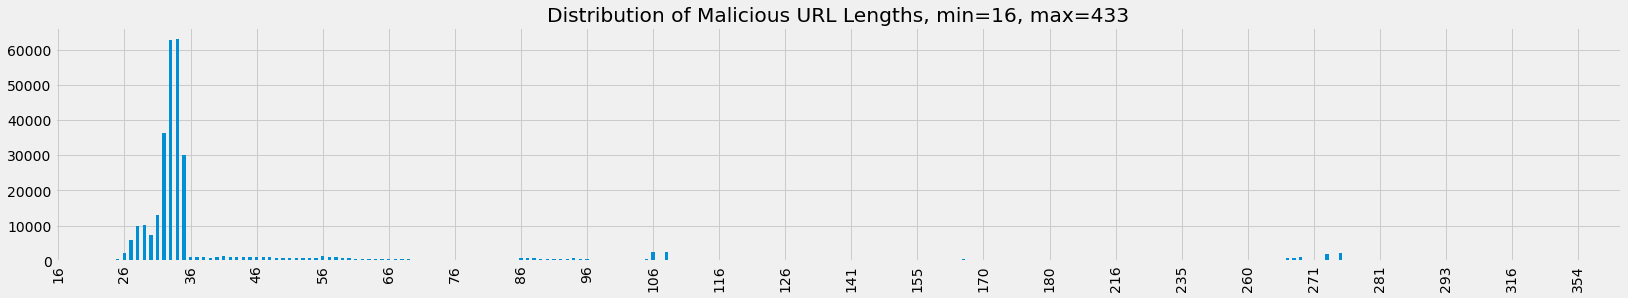

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.style.use('fivethirtyeight')

ax = mdf.url.apply(len).value_counts().sort_index()\
    .plot(kind='bar', figsize=(25, 4), title=f'Distribution of Malicious URL Lengths, min={mdf.url.apply(len).min()}, max={mdf.url.apply(len).max()}')
_ = ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

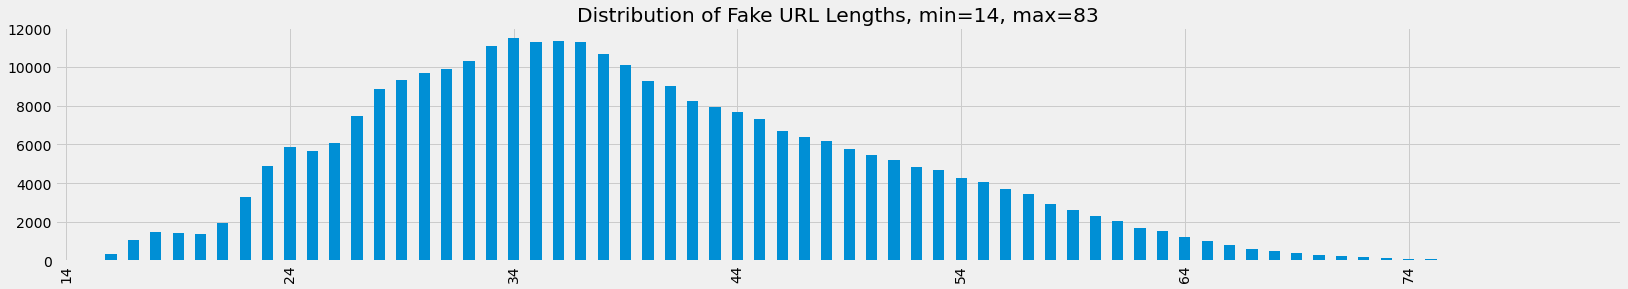

In [6]:
ax = fdf.url.apply(len).value_counts().sort_index()\
    .plot(kind='bar', figsize=(25, 4), title=f'Distribution of Fake URL Lengths, min={fdf.url.apply(len).min()}, max={fdf.url.apply(len).max()}')
_ = ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

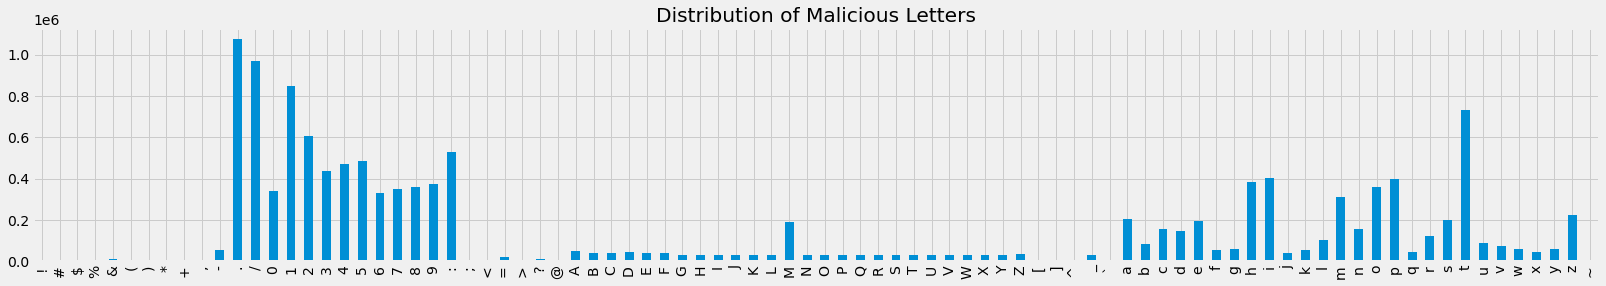

In [7]:
import itertools
from collections import Counter

def get_character_distribution(df):
    s = sorted([(k, v) for k, v in Counter(itertools.chain(*df.url.apply(lambda u: [c for c in u]))).items()])
    s = pd.Series([v for _, v in s], index=[k for k, _ in s])
    return s

ax = get_character_distribution(mdf).plot(kind='bar', figsize=(25, 4), title='Distribution of Malicious Letters')

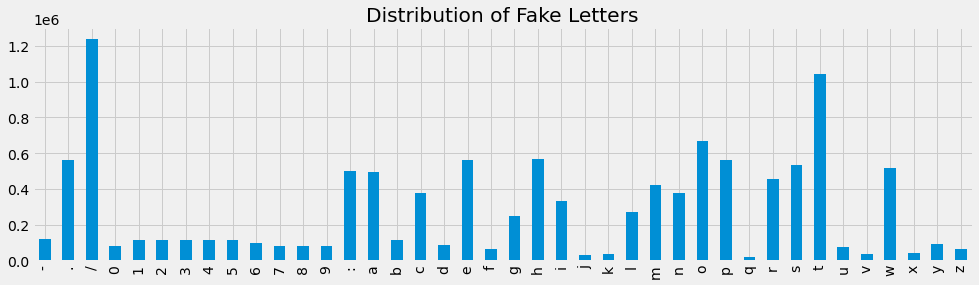

In [8]:
ax = get_character_distribution(fdf).plot(kind='bar', figsize=(15, 4), title='Distribution of Fake Letters')

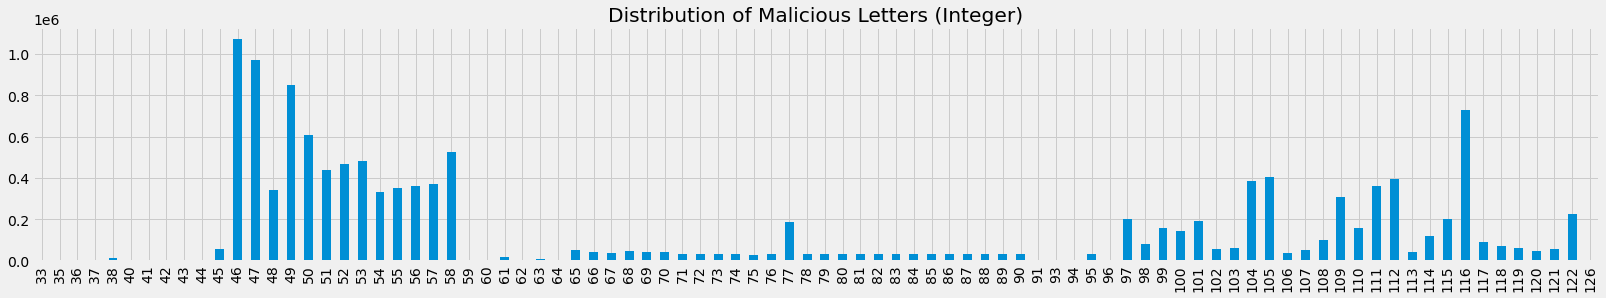

In [9]:
def get_ord_distribution(df):
    s = sorted([(k, v) for k, v in Counter(itertools.chain(*df.url.apply(lambda u: [ord(c) for c in u]))).items()])
    s = pd.Series([v for _, v in s], index=[k for k, _ in s])
    return s

ax = get_ord_distribution(mdf).plot(kind='bar', figsize=(25, 4), title='Distribution of Malicious Letters (Integer)')

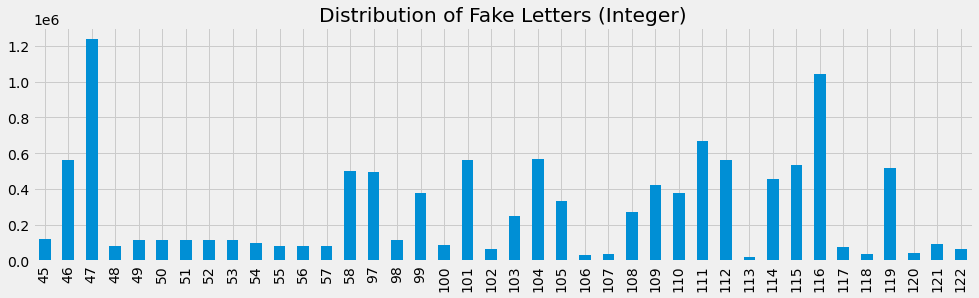

In [10]:
ax = get_ord_distribution(fdf).plot(kind='bar', figsize=(15, 4), title='Distribution of Fake Letters (Integer)')

## Vectorize URLs

In [11]:
import numpy as np

def vectorize(df, max_length):
    X = np.array(list(df.url.apply(lambda u: [ord(c) for c in u] + [0 for _ in range(len(u), max_length)])), dtype=np.double)
    return X

max_length = max(max(mdf.url.apply(len).max(), fdf.url.apply(len).max()), 450)
print(max_length)

M = vectorize(mdf, max_length)
F = vectorize(fdf, max_length)

M.shape, F.shape

450


((294903, 450), (294903, 450))

## Autoencoding

### Datasets and data loaders

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

class UrlDataset(Dataset):
    def __init__(self, X, device):
        self.__device = device
        self.__X = X

    def __len__(self):
        return self.__X.shape[0]

    def __getitem__(self, idx):
        item = self.__X[idx,:]

        return item

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

m_dataset = UrlDataset(X=M, device=device)
f_dataset = UrlDataset(X=F, device=device)

m_dataloader = DataLoader(m_dataset, batch_size=64, shuffle=True, num_workers=1) 
f_dataloader = DataLoader(f_dataset, batch_size=64, shuffle=True, num_workers=1)

cuda


### AE model

In [13]:
from torchvision import datasets
from torchvision import transforms

class AE(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### Learning

In [14]:
def learn(data_loader, input_size, device, epochs=20):
    model = AE(input_size=input_size).double().to(device)
    model.train()
    
    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)
    
    loss_df = []

    for epoch in range(epochs):
        losses = []

        for items in data_loader:
            items = items.to(device)
            optimizer.zero_grad()

            reconstructed = model(items)
            loss = loss_function(reconstructed, items)

            loss.backward()

            optimizer.step()

            losses.append(loss.detach().cpu().numpy().item())

        losses = np.array(losses)

        loss_df.append({
            'epoch': epoch + 1,
            'loss': losses.mean()
        })
        
        print(f'{epoch + 1:03}, {losses.mean():.5f}')

    loss_df = pd.DataFrame(loss_df)
    loss_df.index = loss_df['epoch']
    loss_df = loss_df.drop(columns=['epoch'])
    
    return model, loss_df

In [15]:
m_model, m_loss = learn(m_dataloader, M.shape[1], device)

001, 40.69729
002, 23.34037
003, 21.57728
004, 20.66604
005, 19.53925
006, 18.43908
007, 17.31271
008, 16.88268
009, 16.67882
010, 16.04619
011, 15.73320
012, 15.36572
013, 15.19503
014, 14.95645
015, 14.73917
016, 14.61808
017, 14.53333
018, 14.43027
019, 14.37942
020, 14.32605


In [16]:
f_model, f_loss = learn(f_dataloader, F.shape[1], device)

001, 68.04555
002, 48.74619
003, 43.61743
004, 37.87440
005, 31.67343
006, 28.65478
007, 27.01096
008, 25.89886
009, 24.50368
010, 23.09080
011, 22.30850
012, 21.22333
013, 20.54085
014, 20.09835
015, 19.71120
016, 19.35925
017, 18.92354
018, 18.19207
019, 17.65860
020, 17.37112


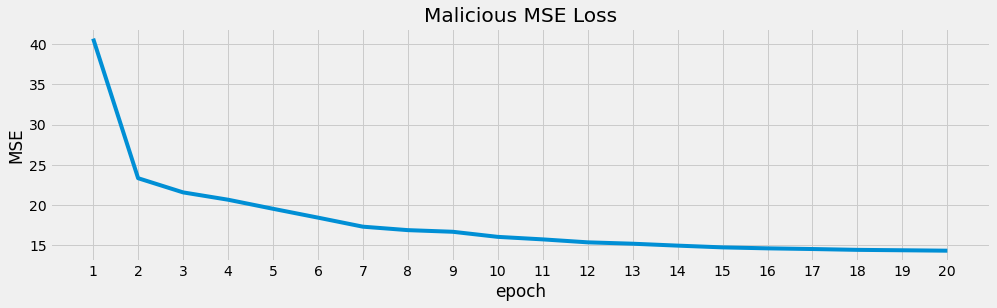

In [17]:
ax = m_loss['loss'].plot(kind='line', figsize=(15, 4), title='Malicious MSE Loss', ylabel='MSE')
_ = ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

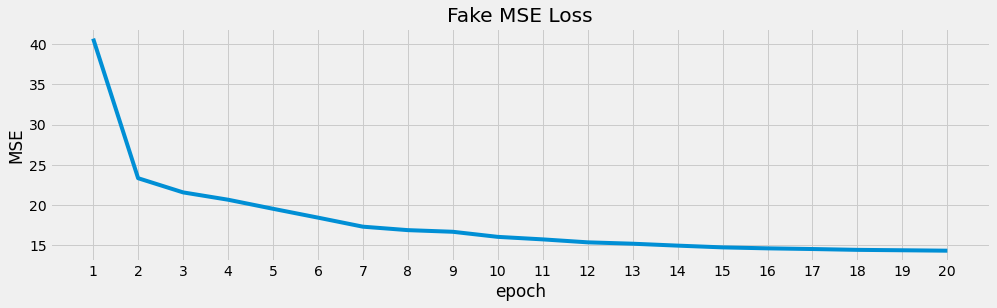

In [18]:
ax = m_loss['loss'].plot(kind='line', figsize=(15, 4), title='Fake MSE Loss', ylabel='MSE')
_ = ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

### Evaluation

In [28]:
_ = m_model.eval()
_ = f_model.eval()

In [62]:
def evaluate(m, f, X, device, urls):
    T = torch.from_numpy(X).to(device)
    
    m_preds = m_model(T).detach().cpu().numpy()
    f_preds = f_model(T).detach().cpu().numpy()
    
    m_dist = np.linalg.norm(X - m_preds, 2, axis=1)
    f_dist = np.linalg.norm(X - f_preds, 2, axis=1)
    
    return pd.DataFrame({
        'urls': list(urls),
        'm_dist': m_dist,
        'f_dist': f_dist
    })

m_result = evaluate(m_model, f_model, M, device, mdf.url)
f_result = evaluate(m_model, f_model, F, device, fdf.url)

m_result.shape, f_result.shape

((294903, 3), (294903, 3))

In [65]:
m_result.head()

,urls,m_dist,f_dist
0,http://113.178.137.103:43063/bin.sh,12.796917,147.769682
1,http://117.195.92.136:52193/bin.sh,14.110015,157.243083
2,http://42.230.86.76:39194/i,13.937121,129.116049
3,http://45.206.219.185:39528/Mozi.m,13.059710,163.499153
4,http://182.117.30.44:43217/bin.sh,12.304893,145.153160


In [68]:
f_result.head()

,urls,m_dist,f_dist
0,http://www.terrell.info:18926/posts/explore/ex...,215.396759,121.751853
1,http://stephens.biz:47993/,94.481302,51.613355
2,http://www.butler.com/explore/faq.htm,141.791605,102.246879
3,https://moore.com:40837/,119.615730,26.017324
4,https://www.nelson-harris.com:34916/main/,151.358979,53.734932


In [66]:
m_result[['m_dist', 'f_dist']].mean()

m_dist     42.201429
f_dist    202.676389
dtype: float64

In [67]:
f_result[['m_dist', 'f_dist']].mean()

m_dist    150.676333
f_dist     82.323130
dtype: float64

In [72]:
m_mean = m_result.m_dist.mean()
f_mean = f_result.f_dist.mean()

m_std = m_result.m_dist.std()
f_std = f_result.f_dist.std()

m_mean, m_std, f_mean, f_std

(42.2014289456109, 67.19424483605282, 82.3231299935951, 31.48630596249839)

In [85]:
s = m_result.m_dist.apply(lambda v: 1 if v <= m_mean + m_std else 0).value_counts().sort_index()
s = s / s.sum()

fn, tp = s.iloc[0], s.iloc[1]

s = f_result.m_dist.apply(lambda v: 1 if v <= m_mean + m_std else 0).value_counts().sort_index()
s = s / s.sum()

tn, fp = s.iloc[0], s.iloc[1]

pd.DataFrame([[tp, fn], [fp, tn]], columns=['p_true', 'p_false'], index=['y_true', 'y_false'])

,p_true,p_false
y_true,0.859639,0.140361
y_false,0.041505,0.958495


In [86]:
s = f_result.f_dist.apply(lambda v: 1 if v <= f_mean + f_std else 0).value_counts().sort_index()
s = s / s.sum()

fn, tp = s.iloc[0], s.iloc[1]

s = m_result.f_dist.apply(lambda v: 1 if v <= f_mean + f_std else 0).value_counts().sort_index()
s = s / s.sum()

tn, fp = s.iloc[0], s.iloc[1]

pd.DataFrame([[tp, fn], [fp, tn]], columns=['p_true', 'p_false'], index=['y_true', 'y_false'])

,p_true,p_false
y_true,0.822365,0.177635
y_false,0.018426,0.981574


In [104]:
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score, f1_score

p_1 = m_result.m_dist.apply(lambda v: 1 if v <= m_mean + m_std else 0)
y_1 = np.ones(len(p_1))

p_0 = f_result.m_dist.apply(lambda v: 1 if v <= m_mean + m_std else 0)
y_0 = np.zeros(len(p_0))

y_pred = pd.concat([p_1, p_0]).values
y_true = np.concatenate([y_1, y_0])

confusion_matrix(y_true, y_pred)

array([[282663,  12240],
       [ 41393, 253510]])

In [105]:
roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred), f1_score(y_true, y_pred)

(0.9090667100707691, 0.8902257823896167, 0.9043383340497598)

In [106]:
p_1 = f_result.f_dist.apply(lambda v: 1 if v <= f_mean + f_std else 0)
y_1 = np.ones(len(p_1))

p_0 = m_result.f_dist.apply(lambda v: 1 if v <= f_mean + f_std else 0)
y_0 = np.zeros(len(p_0))

y_pred = pd.concat([p_1, p_0]).values
y_true = np.concatenate([y_1, y_0])

confusion_matrix(y_true, y_pred)

array([[289469,   5434],
       [ 52385, 242518]])

In [107]:
roc_auc_score(y_true, y_pred), average_precision_score(y_true, y_pred), f1_score(y_true, y_pred)

(0.901969461144851, 0.8931600865406488, 0.8934908953587973)